In [29]:
import numpy as np
import torch
torch.manual_seed(0)
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from itertools import permutations
cmap = plt.cm.RdBu
torch.autograd.set_detect_anomaly(True)
#plt.style.use("dark_paper")
import sys
#sys.path.append(['/home/nwkamp/Classes/Learning-symmetries/'])
from sym.models.perm_models import PIN1,PIN2,PIN3,SNN1,SNN2,SNN3

In [30]:
def f(x):
    ret = np.zeros(len(x))
    for i,dat in enumerate(x):
        #ret[i] = 2*(len(dat[dat>0.5]) % 2) - 1
        #ret[i] = 2*(np.prod(dat) >= 0.5**(len(dat))) - 1
        ret[i] = np.sum(dat) + (np.prod(dat)/(0.5**len(dat)))
    return ret



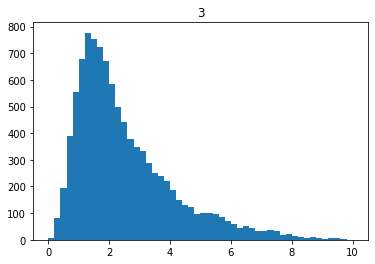

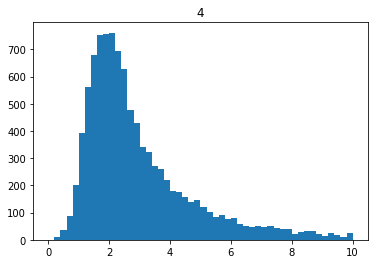

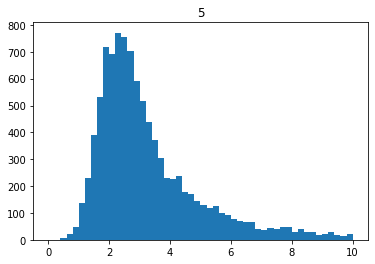

In [31]:
N_list = [3,4,5]
M = int(10000)
BS = 1000
np.random.seed(7)
xtrain_dict = {}
ytrain_dict = {}
xval_dict = {}
yval_dict = {}
trainloader_dict = {}
valloader_dict = {}
for N in N_list:

    xtrain = np.random.rand(M,N)
    xval = np.random.rand(M,N)

    ytrain = f(xtrain)
    yval = f(xval)

    xtrain_dict[N] = torch.from_numpy(xtrain).float()
    ytrain_dict[N] = torch.from_numpy(ytrain).float().view(-1,1)
    xval_dict[N] = torch.from_numpy(xval).float()
    yval_dict[N] = torch.from_numpy(yval).float().view(-1,1)

    trainset = torch.utils.data.TensorDataset(xtrain_dict[N],ytrain_dict[N])
    trainloader_dict[N] = torch.utils.data.DataLoader(trainset,
                                                      batch_size=BS,
                                                      shuffle=True)

    valset = torch.utils.data.TensorDataset(xval_dict[N],yval_dict[N])
    valloader_dict[N] = torch.utils.data.DataLoader(valset,batch_size=BS)


    plt.hist(yval_dict[N].detach().numpy(),range=(0,10),bins=50)
    plt.title(N)
    plt.show()

In [32]:
decayRate = 0.99
lr = 1e-2
criterion = torch.nn.MSELoss(reduction="mean")
mlp = {}
pin = {}
optimizer_mlp = {}
optimizer_pin = {}
lrdecay_mlp = {}
lrdecay_pin = {}
for N in N_list:
    mlp[N] = {'1':SNN1(N),'2':SNN2(N),'3':SNN3(N)}
    pin[N] = {'1':PIN1(N),'2':PIN2(N),'3':PIN3(N)}
    optimizer_mlp[N] = {}
    optimizer_pin[N] = {}
    lrdecay_mlp[N] = {}
    lrdecay_pin[N] = {}
    for i in ['1','2','3']:
        optimizer_mlp[N][i] = torch.optim.SGD(mlp[N][i].parameters(),lr=lr)
        lrdecay_mlp[N][i] = torch.optim.lr_scheduler.ExponentialLR(optimizer_mlp[N][i],gamma=decayRate)
        optimizer_pin[N][i] = torch.optim.SGD(pin[N][i].parameters(),lr=lr)
        lrdecay_pin[N][i] = torch.optim.lr_scheduler.ExponentialLR(optimizer_pin[N][i],gamma=decayRate)

In [33]:
# Define training and validation functions
def train(model,optimizer,x,y):
    model.train()
    yhat = model(x)
    loss = criterion(yhat,y.view(-1,1))
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
def validate(model,x,y):
    model.eval()
    with torch.no_grad():
        yhat = model(x)
        loss = criterion(yhat,y.view(-1,1))
        return loss.item()
# Define early stopping function
def earlyStop(loss_vec,N,eps=1e-6):
    for i in range(N):
        if loss_vec[-i-2] > loss_vec[-i-1]*(1+eps): return False
    return True

def projBv(B,v):
    return torch.matmul(torch.outer(v,v),B)/torch.matmul(v,v)

def Misalignment(A,B):
    d = A.size(0)
    evalA,evecA = torch.eig(A,True)
    M = 0
    for evec in evecA:
        tr1 = projBv(B,evec)
        tr2 = projBv(torch.inverse(B),evec)
        M += torch.sqrt(torch.trace(tr1)*torch.trace(tr2))
    return M-d

def Misalignment2(A,B):
    evalA,evecA = torch.eig(A,True)
    M = 0
    for evec in evecA:
        a = torch.dot(evec,torch.matmul(B,evec))
        b = torch.dot(evec,torch.matmul(torch.inverse(B),evec))
        M += torch.sqrt(a*b)
    return M

def Mmod(mlp_model,pin_model):
    modules_mlp = list(mlp_model.modules())
    modules_pin = list(pin_model.modules())
    mlpW = modules_mlp[0].mlp[0].weight
    phi = modules_pin[0].phi[0].weight
    phiW = torch.ones(phi.size(0),phi.size(0)-1)
    for i in range(phiW.size(0)):
        phiW[i]*=phi[i]
    B = torch.matmul(mlpW,mlpW.transpose(0,1))
    A = torch.matmul(phiW,phiW.transpose(0,1))
    return Misalignment2(A,B),torch.det(B),torch.det(A)

def Frob(mlp_model,pin_model):
    modules_mlp = list(mlp_model.modules())
    modules_pin = list(pin_model.modules())
    mlpW = modules_mlp[0].mlp[0].weight
    phi = modules_pin[0].phi[0].weight
    phiW = torch.ones(phi.size(0),phi.size(0)-1)
    for i in range(phiW.size(0)):
        phiW[i]*=phi[i]
    return torch.trace(torch.matmul(mlpW.T,phiW))
    

with torch.no_grad():
    modules_mlp = list(mlp[3]['1'].modules())
    modules_pin = list(pin[3]['1'].modules())
    mlpW = modules_mlp[0].mlp[0].weight.to('cpu')
    phi = modules_pin[0].phi[0].weight.to('cpu')
    phiW = torch.ones(phi.size(0),phi.size(0)-1)
    for i in range(phiW.size(0)):
        phiW[i]*=phi[i]
    
    A = torch.matmul(mlpW,mlpW.transpose(0,1))
    B = torch.matmul(phiW,phiW.T)
    Ainv = torch.inverse(A)
    Binv = torch.inverse(B)
    print(mlpW)
    print(torch.det(A))
    print(A)
    print(torch.eig(A,True))
    print(Ainv)
    print(torch.matmul(Ainv,A))


Parameter containing:
tensor([[-0.0043,  0.3097, -0.4752],
        [-0.4249, -0.2224,  0.1548],
        [-0.0114,  0.4578, -0.0512]], requires_grad=True)
tensor(0.0075)
tensor([[ 0.3217, -0.1406,  0.1662],
        [-0.1406,  0.2540, -0.1049],
        [ 0.1662, -0.1049,  0.2123]])
torch.return_types.eig(
eigenvalues=tensor([[0.5470, 0.0000],
        [0.0920, 0.0000],
        [0.1491, 0.0000]]),
eigenvectors=tensor([[-0.6935,  0.5719,  0.4383],
        [ 0.5136, -0.0342,  0.8573],
        [-0.5053, -0.8196,  0.2700]]))
tensor([[ 5.7229,  1.6568, -3.6610],
        [ 1.6568,  5.4263,  1.3834],
        [-3.6610,  1.3834,  8.2587]])
tensor([[ 1.0000e+00,  7.3443e-09, -1.0207e-07],
        [-4.4864e-08,  1.0000e+00, -8.1595e-09],
        [-1.2474e-07, -3.8688e-08,  1.0000e+00]])


In [34]:
modelkeys = ['1']
Nkeys = [3,4,5]
losses_train_mlp = {N:{i:[] for i in modelkeys} for N in Nkeys}
losses_val_mlp = {N:{i:[] for i in modelkeys} for N in Nkeys}
losses_train_pin = {N:{i:[] for i in modelkeys} for N in Nkeys}
losses_val_pin = {N:{i:[] for i in modelkeys} for N in Nkeys}

M_dict = {N:[] for N in Nkeys}
det_dict = {N:[] for N in Nkeys}

In [35]:
# Train the model for 100 epochs 
T = 1000
tstart = 1
V = 1
ES = 10
for N in Nkeys:
    for i in modelkeys:
        mlp[N][i].train()
        pin[N][i].train()
for t in range(tstart,T+tstart):
    if t%V==0: print(f"\nEpoch {t:>03d}/{T+tstart-1:^3d}")
    for N in Nkeys:
        for i in modelkeys:
            loss_mlp = 0
            loss_pin = 0
            for n,(x,y) in enumerate(trainloader_dict[N]):
                loss_mlp += train(mlp[N][i],optimizer_mlp[N][i],x,y)
                loss_pin += train(pin[N][i],optimizer_pin[N][i],x,y)
            #loss_mlp = train(mlp[N][i],optimizer_mlp[N][i],xtrain_dict[N],ytrain_dict[N])
            #loss_pin = train(pin[N][i],optimizer_pin[N][i],xtrain_dict[N],ytrain_dict[N])
            losses_train_mlp[N][i].append(loss_mlp/(float(M)/float(BS)))
            losses_train_pin[N][i].append(loss_pin/(float(M)/float(BS)))
            if t%V==0:
                print('###### N,i = '+str(N)+','+i+' #####')
                print(f"Training loss mlp/pin: {loss_mlp/(float(M)/float(BS)):^.6f}/{loss_pin/(float(M)/float(BS)):^.6f}") #,end="\r" 
                
    if t%V == 0:
        for N in Nkeys:
            for i in modelkeys:
                print('###### N,i = '+str(N)+','+i+' #####')
                mlp[N][i].eval()
                pin[N][i].eval()
                if i=='1':
                    mis,detmlp,detpin = Mmod(mlp[N][i],pin[N][i])
                    M_dict[N].append(mis.detach().numpy())
                    det_dict[N].append(detmlp.detach().numpy())
                    print('M:',M_dict[N][-1])
                    print('det:',det_dict[N][-1])
                with torch.no_grad():
                    yhat = mlp[N][i](xval_dict[N])
                    loss_mlp = criterion(yhat,yval_dict[N].view(-1,1)).item()
                    yhat = pin[N][i](xval_dict[N])
                    loss_pin = criterion(yhat,yval_dict[N].view(-1,1)).item()
                    losses_val_mlp[N][i].append(loss_mlp)
                    losses_val_pin[N][i].append(loss_pin)
                    lrdecay_mlp[N][i].step()
                    lrdecay_pin[N][i].step()
                    print(f"Validation loss mlp/pin: {loss_mlp:^.6f}/{loss_pin:^.6f}") #,end="\r"
    if (t/V)>(ES+1):
        tobreak = True
        for N in Nkeys:
            for i in modelkeys:
                if not earlyStop(losses_val_mlp[N][i],ES) or not earlyStop(losses_val_pin[N][i],ES): tobreak = False
        if(tobreak): 
            print('No more learning! Stopping...')
            break



Epoch 001/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 7.812489/7.307229
###### N,i = 4,1 #####
Training loss mlp/pin: 11.269973/11.146202
###### N,i = 5,1 #####
Training loss mlp/pin: 12.344950/6.923105
###### N,i = 3,1 #####
M: 3.4132009
det: 0.0071422337
Validation loss mlp/pin: 6.832834/6.452428
###### N,i = 4,1 #####
M: 5.3866453
det: 0.0079746675
Validation loss mlp/pin: 8.411135/9.786027
###### N,i = 5,1 #####
M: 42.0891
det: 1.3075769e-06
Validation loss mlp/pin: 6.611179/3.913944

Epoch 002/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 5.973900/5.684478
###### N,i = 4,1 #####
Training loss mlp/pin: 5.998887/8.589049
###### N,i = 5,1 #####
Training loss mlp/pin: 4.840718/3.805233
###### N,i = 3,1 #####
M: 3.4983578
det: 0.0066035963
Validation loss mlp/pin: 5.430192/5.211050
###### N,i = 4,1 #####
M: 6.1211886
det: 0.012237927
Validation loss mlp/pin: 3.986638/7.877071
###### N,i = 5,1 #####
M: 121.04348
det: 2.811436e-06
Validation loss mlp/pin: 3.723491/3.525413



###### N,i = 3,1 #####
Training loss mlp/pin: 2.551123/2.597400
###### N,i = 4,1 #####
Training loss mlp/pin: 1.472826/3.742217
###### N,i = 5,1 #####
Training loss mlp/pin: 2.544703/1.556697
###### N,i = 3,1 #####
M: 3.7190073
det: 0.0054731625
Validation loss mlp/pin: 2.585434/2.631523
###### N,i = 4,1 #####
M: 9.691921
det: 0.0204303
Validation loss mlp/pin: 1.505679/3.860200
###### N,i = 5,1 #####
M: 36.26906
det: 0.0001550946
Validation loss mlp/pin: 2.451514/1.574006

Epoch 019/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 2.542721/2.594993
###### N,i = 4,1 #####
Training loss mlp/pin: 1.423707/3.722712
###### N,i = 5,1 #####
Training loss mlp/pin: 2.482998/1.664821
###### N,i = 3,1 #####
M: 3.7168822
det: 0.0055107516
Validation loss mlp/pin: 2.576880/2.628513
###### N,i = 4,1 #####
M: 10.399405
det: 0.020568939
Validation loss mlp/pin: 1.456306/3.838877
###### N,i = 5,1 #####
M: 49.36747
det: 0.00015621631
Validation loss mlp/pin: 2.390549/1.714020

Epoch 020/1000
###### N

###### N,i = 3,1 #####
Training loss mlp/pin: 2.420257/2.589091
###### N,i = 4,1 #####
Training loss mlp/pin: 0.929978/2.997295
###### N,i = 5,1 #####
Training loss mlp/pin: 1.790509/1.538941
###### N,i = 3,1 #####
M: 3.4088807
det: 0.009261702
Validation loss mlp/pin: 2.450499/2.618444
###### N,i = 4,1 #####
M: 8.107443
det: 0.022065004
Validation loss mlp/pin: 0.956310/3.088654
###### N,i = 5,1 #####
M: 41.183926
det: 0.00010520662
Validation loss mlp/pin: 1.727388/1.504780

Epoch 036/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 2.409652/2.589059
###### N,i = 4,1 #####
Training loss mlp/pin: 0.914006/2.935146
###### N,i = 5,1 #####
Training loss mlp/pin: 1.766825/1.547374
###### N,i = 3,1 #####
M: 3.3905146
det: 0.009601409
Validation loss mlp/pin: 2.439840/2.618373
###### N,i = 4,1 #####
M: 10.327126
det: 0.0221359
Validation loss mlp/pin: 0.939970/3.026287
###### N,i = 5,1 #####
M: 26.58983
det: 0.00010132832
Validation loss mlp/pin: 1.704800/1.503612

Epoch 037/1000
###### N

###### N,i = 3,1 #####
Training loss mlp/pin: 2.170345/2.589027
###### N,i = 4,1 #####
Training loss mlp/pin: 0.771291/2.103977
###### N,i = 5,1 #####
Training loss mlp/pin: 1.566579/1.537176
###### N,i = 3,1 #####
M: 3.1978683
det: 0.016026646
Validation loss mlp/pin: 2.200746/2.618018
###### N,i = 4,1 #####
M: 9.798501
det: 0.023246624
Validation loss mlp/pin: 0.793085/2.184976
###### N,i = 5,1 #####
M: 116.407425
det: 5.2795192e-05
Validation loss mlp/pin: 1.524313/1.506002

Epoch 053/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 2.151505/2.589044
###### N,i = 4,1 #####
Training loss mlp/pin: 0.766580/2.065653
###### N,i = 5,1 #####
Training loss mlp/pin: 1.561868/1.538391
###### N,i = 3,1 #####
M: 3.1930313
det: 0.016503995
Validation loss mlp/pin: 2.182061/2.618017
###### N,i = 4,1 #####
M: 11.8727
det: 0.023311099
Validation loss mlp/pin: 0.788317/2.146039
###### N,i = 5,1 #####
M: 41.093346
det: 5.074914e-05
Validation loss mlp/pin: 1.519710/1.504738

Epoch 054/1000
###### 

###### N,i = 3,1 #####
Training loss mlp/pin: 1.820360/2.589012
###### N,i = 4,1 #####
Training loss mlp/pin: 0.719205/1.630046
###### N,i = 5,1 #####
Training loss mlp/pin: 1.522254/1.540473
###### N,i = 3,1 #####
M: 3.2216363
det: 0.024887385
Validation loss mlp/pin: 1.853990/2.617981
###### N,i = 4,1 #####
M: 9.3489895
det: 0.024384147
Validation loss mlp/pin: 0.738219/1.699759
###### N,i = 5,1 #####
M: 132.90773
det: 2.5558957e-05
Validation loss mlp/pin: 1.487101/1.504214

Epoch 070/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 1.799072/2.589007
###### N,i = 4,1 #####
Training loss mlp/pin: 0.717008/1.611408
###### N,i = 5,1 #####
Training loss mlp/pin: 1.521857/1.541784
###### N,i = 3,1 #####
M: 3.2281947
det: 0.025411114
Validation loss mlp/pin: 1.832971/2.617987
###### N,i = 4,1 #####
M: 10.21007
det: 0.024446363
Validation loss mlp/pin: 0.736086/1.680727
###### N,i = 5,1 #####
M: 98.4065
det: 2.4418297e-05
Validation loss mlp/pin: 1.486249/1.506077

Epoch 071/1000
###### 

###### N,i = 4,1 #####
Training loss mlp/pin: 0.688957/1.396621
###### N,i = 5,1 #####
Training loss mlp/pin: 1.511730/1.536159
###### N,i = 3,1 #####
M: 3.3829072
det: 0.03404634
Validation loss mlp/pin: 1.517035/2.617981
###### N,i = 4,1 #####
M: 11.3902445
det: 0.025428994
Validation loss mlp/pin: 0.706667/1.456638
###### N,i = 5,1 #####
M: 237.50055
det: 1.1415436e-05
Validation loss mlp/pin: 1.479303/1.502452

Epoch 087/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 1.462147/2.589010
###### N,i = 4,1 #####
Training loss mlp/pin: 0.687414/1.387011
###### N,i = 5,1 #####
Training loss mlp/pin: 1.511361/1.536968
###### N,i = 3,1 #####
M: 3.3944871
det: 0.03458053
Validation loss mlp/pin: 1.499285/2.617979
###### N,i = 4,1 #####
M: 10.148824
det: 0.025509087
Validation loss mlp/pin: 0.704885/1.446482
###### N,i = 5,1 #####
M: 256.0105
det: 1.0854992e-05
Validation loss mlp/pin: 1.478995/1.501779

Epoch 088/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 1.444535/2.589002
######

###### N,i = 3,1 #####
Training loss mlp/pin: 1.216934/2.589002
###### N,i = 4,1 #####
Training loss mlp/pin: 0.663590/1.269113
###### N,i = 5,1 #####
Training loss mlp/pin: 1.507669/1.536508
###### N,i = 3,1 #####
M: 3.571777
det: 0.042151324
Validation loss mlp/pin: 1.256297/2.617978
###### N,i = 4,1 #####
M: 5.7626915
det: 0.026201107
Validation loss mlp/pin: 0.680318/1.322832
###### N,i = 5,1 #####
M: 388.02246
det: 3.8439985e-06
Validation loss mlp/pin: 1.476488/1.501682

Epoch 104/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 1.204126/2.589003
###### N,i = 4,1 #####
Training loss mlp/pin: 0.662232/1.263440
###### N,i = 5,1 #####
Training loss mlp/pin: 1.507274/1.534397
###### N,i = 3,1 #####
M: 3.5820818
det: 0.04257236
Validation loss mlp/pin: 1.243603/2.617978
###### N,i = 4,1 #####
M: 12.63686
det: 0.02623637
Validation loss mlp/pin: 0.678797/1.316927
###### N,i = 5,1 #####
M: 263.64502
det: 3.523201e-06
Validation loss mlp/pin: 1.476348/1.504192

Epoch 105/1000
###### N,

###### N,i = 4,1 #####
Training loss mlp/pin: 0.639996/1.190839
###### N,i = 5,1 #####
Training loss mlp/pin: 1.505328/1.536676
###### N,i = 3,1 #####
M: 3.7309773
det: 0.048647452
Validation loss mlp/pin: 1.075032/2.617978
###### N,i = 4,1 #####
M: 12.071464
det: 0.026553206
Validation loss mlp/pin: 0.655685/1.241348
###### N,i = 5,1 #####
M: 1220.202
det: 3.805494e-07
Validation loss mlp/pin: 1.474656/1.504582

Epoch 121/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 1.026076/2.588997
###### N,i = 4,1 #####
Training loss mlp/pin: 0.638684/1.187249
###### N,i = 5,1 #####
Training loss mlp/pin: 1.505081/1.535900
###### N,i = 3,1 #####
M: 3.7388372
det: 0.048970304
Validation loss mlp/pin: 1.066417/2.617978
###### N,i = 4,1 #####
M: 12.313057
det: 0.026558693
Validation loss mlp/pin: 0.654320/1.237542
###### N,i = 5,1 #####
M: 974.2568
det: 2.91975e-07
Validation loss mlp/pin: 1.474572/1.503054

Epoch 122/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 1.017637/2.588999
###### N,

###### N,i = 4,1 #####
Training loss mlp/pin: 0.618175/1.139135
###### N,i = 5,1 #####
Training loss mlp/pin: 1.503232/1.535925
###### N,i = 3,1 #####
M: 3.8500032
det: 0.053635657
Validation loss mlp/pin: 0.952195/2.617978
###### N,i = 4,1 #####
M: 7.359084
det: 0.026526017
Validation loss mlp/pin: 0.632914/1.187645
###### N,i = 5,1 #####
M: 1086.6599
det: 4.0185418e-07
Validation loss mlp/pin: 1.473047/1.501815

Epoch 138/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.906056/2.588998
###### N,i = 4,1 #####
Training loss mlp/pin: 0.616869/1.136639
###### N,i = 5,1 #####
Training loss mlp/pin: 1.503088/1.535615
###### N,i = 3,1 #####
M: 3.8559666
det: 0.053893525
Validation loss mlp/pin: 0.946334/2.617978
###### N,i = 4,1 #####
M: 11.82
det: 0.026518451
Validation loss mlp/pin: 0.631620/1.185121
###### N,i = 5,1 #####
M: 1134.1256
det: 4.9232113e-07
Validation loss mlp/pin: 1.472953/1.501527

Epoch 139/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.900348/2.588992
###### N,

###### N,i = 3,1 #####
Training loss mlp/pin: 0.828152/2.588993
###### N,i = 4,1 #####
Training loss mlp/pin: 0.598157/1.102942
###### N,i = 5,1 #####
Training loss mlp/pin: 1.501512/1.534735
###### N,i = 3,1 #####
M: 3.936199
det: 0.05748388
Validation loss mlp/pin: 0.867974/2.617971
###### N,i = 4,1 #####
M: 9.081855
det: 0.026262648
Validation loss mlp/pin: 0.612088/1.150359
###### N,i = 5,1 #####
M: 377.86044
det: 3.0352444e-06
Validation loss mlp/pin: 1.471740/1.501535

Epoch 155/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.824113/2.588997
###### N,i = 4,1 #####
Training loss mlp/pin: 0.597027/1.101150
###### N,i = 5,1 #####
Training loss mlp/pin: 1.501471/1.535361
###### N,i = 3,1 #####
M: 3.9401898
det: 0.05767045
Validation loss mlp/pin: 0.863904/2.617973
###### N,i = 4,1 #####
M: 16.867931
det: 0.026236339
Validation loss mlp/pin: 0.610949/1.148516
###### N,i = 5,1 #####
M: 382.4917
det: 3.2491469e-06
Validation loss mlp/pin: 1.471685/1.501646

Epoch 156/1000
###### N,

###### N,i = 4,1 #####
Training loss mlp/pin: 0.579988/1.076719
###### N,i = 5,1 #####
Training loss mlp/pin: 1.500153/1.535161
###### N,i = 3,1 #####
M: 3.9964595
det: 0.0603891
Validation loss mlp/pin: 0.808716/2.617969
###### N,i = 4,1 #####
M: 14.095703
det: 0.025805073
Validation loss mlp/pin: 0.593665/1.123251
###### N,i = 5,1 #####
M: 330.4647
det: 7.3554706e-06
Validation loss mlp/pin: 1.470589/1.501789

Epoch 172/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.766620/2.588997
###### N,i = 4,1 #####
Training loss mlp/pin: 0.578946/1.075388
###### N,i = 5,1 #####
Training loss mlp/pin: 1.500179/1.535040
###### N,i = 3,1 #####
M: 3.9992156
det: 0.060528938
Validation loss mlp/pin: 0.805802/2.617970
###### N,i = 4,1 #####
M: 9.212589
det: 0.025777174
Validation loss mlp/pin: 0.592632/1.121858
###### N,i = 5,1 #####
M: 395.10443
det: 7.624477e-06
Validation loss mlp/pin: 1.470626/1.503216

Epoch 173/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.763792/2.588996
###### N,

###### N,i = 4,1 #####
Training loss mlp/pin: 0.563617/1.057134
###### N,i = 5,1 #####
Training loss mlp/pin: 1.499241/1.536016
###### N,i = 3,1 #####
M: 4.039736
det: 0.06264703
Validation loss mlp/pin: 0.765794/2.617969
###### N,i = 4,1 #####
M: 8.611742
det: 0.025356961
Validation loss mlp/pin: 0.577330/1.102971
###### N,i = 5,1 #####
M: 339.60547
det: 1.2490466e-05
Validation loss mlp/pin: 1.469619/1.501658

Epoch 189/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.725080/2.588995
###### N,i = 4,1 #####
Training loss mlp/pin: 0.562693/1.056123
###### N,i = 5,1 #####
Training loss mlp/pin: 1.498939/1.534747
###### N,i = 3,1 #####
M: 4.041958
det: 0.06276722
Validation loss mlp/pin: 0.763656/2.617969
###### N,i = 4,1 #####
M: 13.279987
det: 0.025330102
Validation loss mlp/pin: 0.576456/1.101945
###### N,i = 5,1 #####
M: 125.31147
det: 1.2826674e-05
Validation loss mlp/pin: 1.469616/1.502620

Epoch 190/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.723012/2.588990
###### N,

###### N,i = 3,1 #####
Training loss mlp/pin: 0.695885/2.588993
###### N,i = 4,1 #####
Training loss mlp/pin: 0.549706/1.042262
###### N,i = 5,1 #####
Training loss mlp/pin: 1.498029/1.534851
###### N,i = 3,1 #####
M: 4.071663
det: 0.06443945
Validation loss mlp/pin: 0.733947/2.617970
###### N,i = 4,1 #####
M: 10.759811
det: 0.024917781
Validation loss mlp/pin: 0.563484/1.087534
###### N,i = 5,1 #####
M: 116.06593
det: 1.841338e-05
Validation loss mlp/pin: 1.468734/1.501721

Epoch 206/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.694304/2.588997
###### N,i = 4,1 #####
Training loss mlp/pin: 0.548974/1.041519
###### N,i = 5,1 #####
Training loss mlp/pin: 1.497967/1.535035
###### N,i = 3,1 #####
M: 4.0732317
det: 0.06453111
Validation loss mlp/pin: 0.732339/2.617969
###### N,i = 4,1 #####
M: 10.015419
det: 0.024888065
Validation loss mlp/pin: 0.562755/1.086758
###### N,i = 5,1 #####
M: 286.48483
det: 1.8764815e-05
Validation loss mlp/pin: 1.468680/1.501744

Epoch 207/1000
###### N

###### N,i = 3,1 #####
Training loss mlp/pin: 0.672168/2.588991
###### N,i = 4,1 #####
Training loss mlp/pin: 0.537762/1.030651
###### N,i = 5,1 #####
Training loss mlp/pin: 1.497166/1.534955
###### N,i = 3,1 #####
M: 4.094789
det: 0.06583043
Validation loss mlp/pin: 0.709788/2.617971
###### N,i = 4,1 #####
M: 14.643901
det: 0.024492202
Validation loss mlp/pin: 0.551560/1.075486
###### N,i = 5,1 #####
M: 240.14209
det: 2.4467274e-05
Validation loss mlp/pin: 1.468027/1.501548

Epoch 223/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.670960/2.588991
###### N,i = 4,1 #####
Training loss mlp/pin: 0.537127/1.030037
###### N,i = 5,1 #####
Training loss mlp/pin: 1.497155/1.535145
###### N,i = 3,1 #####
M: 4.095934
det: 0.06590206
Validation loss mlp/pin: 0.708555/2.617971
###### N,i = 4,1 #####
M: 6.680573
det: 0.024466936
Validation loss mlp/pin: 0.550928/1.074874
###### N,i = 5,1 #####
M: 253.59268
det: 2.4817662e-05
Validation loss mlp/pin: 1.467985/1.501559

Epoch 224/1000
###### N,

###### N,i = 3,1 #####
Training loss mlp/pin: 0.653881/2.588990
###### N,i = 4,1 #####
Training loss mlp/pin: 0.527826/1.021484
###### N,i = 5,1 #####
Training loss mlp/pin: 1.496496/1.535013
###### N,i = 3,1 #####
M: 4.1122785
det: 0.066953935
Validation loss mlp/pin: 0.691125/2.617972
###### N,i = 4,1 #####
M: 14.970695
det: 0.024123058
Validation loss mlp/pin: 0.541434/1.065939
###### N,i = 5,1 #####
M: 166.81377
det: 3.0207622e-05
Validation loss mlp/pin: 1.467419/1.502094

Epoch 240/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.652946/2.588997
###### N,i = 4,1 #####
Training loss mlp/pin: 0.527341/1.020990
###### N,i = 5,1 #####
Training loss mlp/pin: 1.496427/1.535198
###### N,i = 3,1 #####
M: 4.1130705
det: 0.06700852
Validation loss mlp/pin: 0.690162/2.617972
###### N,i = 4,1 #####
M: 8.084831
det: 0.024104206
Validation loss mlp/pin: 0.540884/1.065455
###### N,i = 5,1 #####
M: 117.76005
det: 3.051584e-05
Validation loss mlp/pin: 1.467398/1.501991

Epoch 241/1000
###### 

###### N,i = 3,1 #####
Training loss mlp/pin: 0.639545/2.588993
###### N,i = 4,1 #####
Training loss mlp/pin: 0.519713/1.014226
###### N,i = 5,1 #####
Training loss mlp/pin: 1.495859/1.535160
###### N,i = 3,1 #####
M: 4.125308
det: 0.06784987
Validation loss mlp/pin: 0.676480/2.617972
###### N,i = 4,1 #####
M: 9.015205
det: 0.023808304
Validation loss mlp/pin: 0.532937/1.058299
###### N,i = 5,1 #####
M: 269.1988
det: 3.5445602e-05
Validation loss mlp/pin: 1.466897/1.501704

Epoch 257/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.638800/2.588988
###### N,i = 4,1 #####
Training loss mlp/pin: 0.519285/1.013850
###### N,i = 5,1 #####
Training loss mlp/pin: 1.495796/1.534920
###### N,i = 3,1 #####
M: 4.125989
det: 0.067897685
Validation loss mlp/pin: 0.675721/2.617972
###### N,i = 4,1 #####
M: 8.218118
det: 0.023790196
Validation loss mlp/pin: 0.532488/1.057902
###### N,i = 5,1 #####
M: 180.97354
det: 3.574055e-05
Validation loss mlp/pin: 1.466869/1.501757

Epoch 258/1000
###### N,i 

###### N,i = 4,1 #####
Training loss mlp/pin: 0.512960/1.008455
###### N,i = 5,1 #####
Training loss mlp/pin: 1.495333/1.535025
###### N,i = 3,1 #####
M: 4.135604
det: 0.06859142
Validation loss mlp/pin: 0.664857/2.617972
###### N,i = 4,1 #####
M: 12.37383
det: 0.02353051
Validation loss mlp/pin: 0.525924/1.052148
###### N,i = 5,1 #####
M: 138.13034
det: 4.0255905e-05
Validation loss mlp/pin: 1.466432/1.501590

Epoch 274/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.627585/2.588990
###### N,i = 4,1 #####
Training loss mlp/pin: 0.512610/1.008149
###### N,i = 5,1 #####
Training loss mlp/pin: 1.495283/1.534899
###### N,i = 3,1 #####
M: 4.1361475
det: 0.06863138
Validation loss mlp/pin: 0.664250/2.617972
###### N,i = 4,1 #####
M: 12.304045
det: 0.02351571
Validation loss mlp/pin: 0.525549/1.051822
###### N,i = 5,1 #####
M: 172.35135
det: 4.0528237e-05
Validation loss mlp/pin: 1.466407/1.501601

Epoch 275/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.627003/2.588988
###### N,i

###### N,i = 3,1 #####
Training loss mlp/pin: 0.619060/2.588988
###### N,i = 4,1 #####
Training loss mlp/pin: 0.507285/1.003755
###### N,i = 5,1 #####
Training loss mlp/pin: 1.494884/1.534870
###### N,i = 3,1 #####
M: 4.1434226
det: 0.06918907
Validation loss mlp/pin: 0.655527/2.617972
###### N,i = 4,1 #####
M: 4.775921
det: 0.02329896
Validation loss mlp/pin: 0.520074/1.047144
###### N,i = 5,1 #####
M: 91.44243
det: 4.4632958e-05
Validation loss mlp/pin: 1.466056/1.501704

Epoch 291/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.618581/2.588990
###### N,i = 4,1 #####
Training loss mlp/pin: 0.506978/1.003498
###### N,i = 5,1 #####
Training loss mlp/pin: 1.494916/1.535164
###### N,i = 3,1 #####
M: 4.1438465
det: 0.06922172
Validation loss mlp/pin: 0.655039/2.617972
###### N,i = 4,1 #####
M: 8.289818
det: 0.023286937
Validation loss mlp/pin: 0.519763/1.046877
###### N,i = 5,1 #####
M: 102.683945
det: 4.4867546e-05
Validation loss mlp/pin: 1.466035/1.501647

Epoch 292/1000
###### N,

###### N,i = 4,1 #####
Training loss mlp/pin: 0.502618/0.999928
###### N,i = 5,1 #####
Training loss mlp/pin: 1.494530/1.534995
###### N,i = 3,1 #####
M: 4.149884
det: 0.06969668
Validation loss mlp/pin: 0.647992/2.617972
###### N,i = 4,1 #####
M: 16.050426
det: 0.023103591
Validation loss mlp/pin: 0.515251/1.043043
###### N,i = 5,1 #####
M: 137.19537
det: 4.8398888e-05
Validation loss mlp/pin: 1.465726/1.501587

Epoch 308/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.611306/2.588988
###### N,i = 4,1 #####
Training loss mlp/pin: 0.502359/0.999726
###### N,i = 5,1 #####
Training loss mlp/pin: 1.494492/1.534829
###### N,i = 3,1 #####
M: 4.150224
det: 0.069724016
Validation loss mlp/pin: 0.647596/2.617972
###### N,i = 4,1 #####
M: 10.589299
det: 0.023092922
Validation loss mlp/pin: 0.514997/1.042827
###### N,i = 5,1 #####
M: 223.29405
det: 4.8613212e-05
Validation loss mlp/pin: 1.465715/1.501700

Epoch 309/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.610925/2.588988
###### 

###### N,i = 4,1 #####
Training loss mlp/pin: 0.498770/0.996796
###### N,i = 5,1 #####
Training loss mlp/pin: 1.494213/1.534895
###### N,i = 3,1 #####
M: 4.1550913
det: 0.07012273
Validation loss mlp/pin: 0.641868/2.617973
###### N,i = 4,1 #####
M: 12.025046
det: 0.022935383
Validation loss mlp/pin: 0.511280/1.039678
###### N,i = 5,1 #####
M: 246.93079
det: 5.1694864e-05
Validation loss mlp/pin: 1.465463/1.501629

Epoch 325/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.605401/2.588987
###### N,i = 4,1 #####
Training loss mlp/pin: 0.498540/0.996619
###### N,i = 5,1 #####
Training loss mlp/pin: 1.494197/1.534885
###### N,i = 3,1 #####
M: 4.1553545
det: 0.07014499
Validation loss mlp/pin: 0.641544/2.617973
###### N,i = 4,1 #####
M: 14.450275
det: 0.022926291
Validation loss mlp/pin: 0.511067/1.039498
###### N,i = 5,1 #####
M: 215.14664
det: 5.1883784e-05
Validation loss mlp/pin: 1.465449/1.501643

Epoch 326/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.605091/2.588989
######

###### N,i = 4,1 #####
Training loss mlp/pin: 0.495527/0.994191
###### N,i = 5,1 #####
Training loss mlp/pin: 1.493940/1.534849
###### N,i = 3,1 #####
M: 4.159191
det: 0.07047203
Validation loss mlp/pin: 0.636854/2.617973
###### N,i = 4,1 #####
M: 16.927668
det: 0.022790892
Validation loss mlp/pin: 0.507971/1.036904
###### N,i = 5,1 #####
M: 103.8324
det: 5.4595384e-05
Validation loss mlp/pin: 1.465236/1.501633

Epoch 342/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.600568/2.588988
###### N,i = 4,1 #####
Training loss mlp/pin: 0.495347/0.994049
###### N,i = 5,1 #####
Training loss mlp/pin: 1.493922/1.534846
###### N,i = 3,1 #####
M: 4.1594014
det: 0.070490435
Validation loss mlp/pin: 0.636589/2.617973
###### N,i = 4,1 #####
M: 15.978107
det: 0.02278304
Validation loss mlp/pin: 0.507795/1.036756
###### N,i = 5,1 #####
M: 92.71515
det: 5.4750013e-05
Validation loss mlp/pin: 1.465222/1.501608

Epoch 343/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.600311/2.588987
###### N,

###### N,i = 4,1 #####
Training loss mlp/pin: 0.492832/0.992035
###### N,i = 5,1 #####
Training loss mlp/pin: 1.493707/1.534797
###### N,i = 3,1 #####
M: 4.1624837
det: 0.07076199
Validation loss mlp/pin: 0.632732/2.617973
###### N,i = 4,1 #####
M: 14.606896
det: 0.022667935
Validation loss mlp/pin: 0.505223/1.034607
###### N,i = 5,1 #####
M: 276.79984
det: 5.7109297e-05
Validation loss mlp/pin: 1.465035/1.501638

Epoch 359/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.596593/2.588988
###### N,i = 4,1 #####
Training loss mlp/pin: 0.492686/0.991920
###### N,i = 5,1 #####
Training loss mlp/pin: 1.493716/1.534908
###### N,i = 3,1 #####
M: 4.162652
det: 0.07077725
Validation loss mlp/pin: 0.632513/2.617973
###### N,i = 4,1 #####
M: 13.388954
det: 0.022661453
Validation loss mlp/pin: 0.505076/1.034485
###### N,i = 5,1 #####
M: 79.02734
det: 5.7245303e-05
Validation loss mlp/pin: 1.465025/1.501643

Epoch 360/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.596382/2.588988
###### N

###### N,i = 3,1 #####
Training loss mlp/pin: 0.593481/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.490580/0.990264
###### N,i = 5,1 #####
Training loss mlp/pin: 1.493547/1.534915
###### N,i = 3,1 #####
M: 4.1650763
det: 0.07100025
Validation loss mlp/pin: 0.629324/2.617973
###### N,i = 4,1 #####
M: 12.705433
det: 0.022564847
Validation loss mlp/pin: 0.502938/1.032703
###### N,i = 5,1 #####
M: 225.43715
det: 5.9272148e-05
Validation loss mlp/pin: 1.464873/1.501632

Epoch 376/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.593307/2.588987
###### N,i = 4,1 #####
Training loss mlp/pin: 0.490462/0.990163
###### N,i = 5,1 #####
Training loss mlp/pin: 1.493499/1.534795
###### N,i = 3,1 #####
M: 4.165224
det: 0.07101349
Validation loss mlp/pin: 0.629143/2.617973
###### N,i = 4,1 #####
M: 13.275943
det: 0.022559276
Validation loss mlp/pin: 0.502816/1.032602
###### N,i = 5,1 #####
M: 167.03174
det: 5.9400907e-05
Validation loss mlp/pin: 1.464864/1.501624

Epoch 377/1000
###### 

###### N,i = 3,1 #####
Training loss mlp/pin: 0.590733/2.588988
###### N,i = 4,1 #####
Training loss mlp/pin: 0.488689/0.988774
###### N,i = 5,1 #####
Training loss mlp/pin: 1.493347/1.534778
###### N,i = 3,1 #####
M: 4.167339
det: 0.0712065
Validation loss mlp/pin: 0.626504/2.617973
###### N,i = 4,1 #####
M: 12.970613
det: 0.02247837
Validation loss mlp/pin: 0.501026/1.031118
###### N,i = 5,1 #####
M: 125.74272
det: 6.116359e-05
Validation loss mlp/pin: 1.464733/1.501631

Epoch 393/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.590586/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.488584/0.988695
###### N,i = 5,1 #####
Training loss mlp/pin: 1.493333/1.534757
###### N,i = 3,1 #####
M: 4.1674576
det: 0.07121758
Validation loss mlp/pin: 0.626354/2.617973
###### N,i = 4,1 #####
M: 10.007103
det: 0.022473749
Validation loss mlp/pin: 0.500924/1.031034
###### N,i = 5,1 #####
M: 174.57947
det: 6.1268176e-05
Validation loss mlp/pin: 1.464726/1.501636

Epoch 394/1000
###### N,i

###### N,i = 3,1 #####
Training loss mlp/pin: 0.588457/2.588987
###### N,i = 4,1 #####
Training loss mlp/pin: 0.487100/0.987541
###### N,i = 5,1 #####
Training loss mlp/pin: 1.493214/1.534781
###### N,i = 3,1 #####
M: 4.1692953
det: 0.07138488
Validation loss mlp/pin: 0.624164/2.617973
###### N,i = 4,1 #####
M: 12.138502
det: 0.022405442
Validation loss mlp/pin: 0.499424/1.029795
###### N,i = 5,1 #####
M: 152.0526
det: 6.2787134e-05
Validation loss mlp/pin: 1.464615/1.501640

Epoch 410/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.588335/2.588987
###### N,i = 4,1 #####
Training loss mlp/pin: 0.487016/0.987472
###### N,i = 5,1 #####
Training loss mlp/pin: 1.493212/1.534820
###### N,i = 3,1 #####
M: 4.1693964
det: 0.071394295
Validation loss mlp/pin: 0.624040/2.617973
###### N,i = 4,1 #####
M: 6.9836655
det: 0.02240147
Validation loss mlp/pin: 0.499338/1.029724
###### N,i = 5,1 #####
M: 73.42426
det: 6.287719e-05
Validation loss mlp/pin: 1.464609/1.501631

Epoch 411/1000
###### N,

###### N,i = 3,1 #####
Training loss mlp/pin: 0.586559/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.485786/0.986506
###### N,i = 5,1 #####
Training loss mlp/pin: 1.493097/1.534775
###### N,i = 3,1 #####
M: 4.1708508
det: 0.07153145
Validation loss mlp/pin: 0.622216/2.617973
###### N,i = 4,1 #####
M: 12.738602
det: 0.022344243
Validation loss mlp/pin: 0.498081/1.028690
###### N,i = 5,1 #####
M: 107.52937
det: 6.417404e-05
Validation loss mlp/pin: 1.464515/1.501633

Epoch 427/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.586458/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.485721/0.986453
###### N,i = 5,1 #####
Training loss mlp/pin: 1.493087/1.534767
###### N,i = 3,1 #####
M: 4.1709337
det: 0.07153933
Validation loss mlp/pin: 0.622112/2.617973
###### N,i = 4,1 #####
M: 5.2743864
det: 0.022340948
Validation loss mlp/pin: 0.498009/1.028631
###### N,i = 5,1 #####
M: 84.41189
det: 6.424903e-05
Validation loss mlp/pin: 1.464509/1.501626

Epoch 428/1000
###### N,

###### N,i = 4,1 #####
Training loss mlp/pin: 0.484695/0.985653
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492994/1.534763
###### N,i = 3,1 #####
M: 4.1721706
det: 0.0716559
Validation loss mlp/pin: 0.620592/2.617973
###### N,i = 4,1 #####
M: 7.939839
det: 0.022292614
Validation loss mlp/pin: 0.496957/1.027765
###### N,i = 5,1 #####
M: 228.25432
det: 6.536062e-05
Validation loss mlp/pin: 1.464429/1.501626

Epoch 444/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.584897/2.588987
###### N,i = 4,1 #####
Training loss mlp/pin: 0.484636/0.985605
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492984/1.534736
###### N,i = 3,1 #####
M: 4.1722383
det: 0.07166243
Validation loss mlp/pin: 0.620505/2.617973
###### N,i = 4,1 #####
M: 10.72064
det: 0.02228985
Validation loss mlp/pin: 0.496897/1.027715
###### N,i = 5,1 #####
M: 181.89543
det: 6.541326e-05
Validation loss mlp/pin: 1.464425/1.501624

Epoch 445/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.584813/2.588986
###### N,i =

###### N,i = 4,1 #####
Training loss mlp/pin: 0.483777/0.984934
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492910/1.534746
###### N,i = 3,1 #####
M: 4.173231
det: 0.07175874
Validation loss mlp/pin: 0.619234/2.617973
###### N,i = 4,1 #####
M: 10.119459
det: 0.022248872
Validation loss mlp/pin: 0.496016/1.026991
###### N,i = 5,1 #####
M: 196.01532
det: 6.636296e-05
Validation loss mlp/pin: 1.464358/1.501632

Epoch 461/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.583590/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.483726/0.984899
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492910/1.534772
###### N,i = 3,1 #####
M: 4.1732883
det: 0.07176427
Validation loss mlp/pin: 0.619161/2.617973
###### N,i = 4,1 #####
M: 15.846439
det: 0.022246517
Validation loss mlp/pin: 0.495966/1.026950
###### N,i = 5,1 #####
M: 128.94635
det: 6.641101e-05
Validation loss mlp/pin: 1.464354/1.501631

Epoch 462/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.583520/2.588987
###### N,

###### N,i = 4,1 #####
Training loss mlp/pin: 0.483008/0.984330
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492848/1.534774
###### N,i = 3,1 #####
M: 4.1741085
det: 0.07184503
Validation loss mlp/pin: 0.618098/2.617973
###### N,i = 4,1 #####
M: 13.480672
det: 0.022212034
Validation loss mlp/pin: 0.495224/1.026343
###### N,i = 5,1 #####
M: 94.52069
det: 6.722634e-05
Validation loss mlp/pin: 1.464298/1.501635

Epoch 478/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.582497/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.482967/0.984299
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492847/1.534790
###### N,i = 3,1 #####
M: 4.1741543
det: 0.07184963
Validation loss mlp/pin: 0.618037/2.617973
###### N,i = 4,1 #####
M: 15.56851
det: 0.022210045
Validation loss mlp/pin: 0.495182/1.026308
###### N,i = 5,1 #####
M: 162.85957
det: 6.7277026e-05
Validation loss mlp/pin: 1.464295/1.501636

Epoch 479/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.582439/2.588987
###### N,

###### N,i = 4,1 #####
Training loss mlp/pin: 0.482367/0.983826
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492784/1.534754
###### N,i = 3,1 #####
M: 4.1748133
det: 0.07191649
Validation loss mlp/pin: 0.617146/2.617973
###### N,i = 4,1 #####
M: 4.1590304
det: 0.022180973
Validation loss mlp/pin: 0.494559/1.025799
###### N,i = 5,1 #####
M: 83.22151
det: 6.796807e-05
Validation loss mlp/pin: 1.464246/1.501624

Epoch 495/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.581581/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.482331/0.983798
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492780/1.534752
###### N,i = 3,1 #####
M: 4.174851
det: 0.07192032
Validation loss mlp/pin: 0.617095/2.617973
###### N,i = 4,1 #####
M: 7.5310297
det: 0.022179345
Validation loss mlp/pin: 0.494523/1.025770
###### N,i = 5,1 #####
M: 138.72894
det: 6.798659e-05
Validation loss mlp/pin: 1.464243/1.501623

Epoch 496/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.581532/2.588986
###### N,i

###### N,i = 4,1 #####
Training loss mlp/pin: 0.481829/0.983397
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492735/1.534756
###### N,i = 3,1 #####
M: 4.175401
det: 0.07197653
Validation loss mlp/pin: 0.616347/2.617973
###### N,i = 4,1 #####
M: 9.692485
det: 0.02215496
Validation loss mlp/pin: 0.494001/1.025342
###### N,i = 5,1 #####
M: 84.84189
det: 6.858647e-05
Validation loss mlp/pin: 1.464204/1.501627

Epoch 512/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.580812/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.481798/0.983375
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492735/1.534768
###### N,i = 3,1 #####
M: 4.1754327
det: 0.07197979
Validation loss mlp/pin: 0.616305/2.617973
###### N,i = 4,1 #####
M: 14.466486
det: 0.022153568
Validation loss mlp/pin: 0.493971/1.025318
###### N,i = 5,1 #####
M: 49.817226
det: 6.862291e-05
Validation loss mlp/pin: 1.464202/1.501627

Epoch 513/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.580771/2.588986
###### N,i =

###### N,i = 3,1 #####
Training loss mlp/pin: 0.580203/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.481373/0.983039
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492694/1.534769
###### N,i = 3,1 #####
M: 4.175891
det: 0.072027005
Validation loss mlp/pin: 0.615677/2.617973
###### N,i = 4,1 #####
M: 14.526567
det: 0.022132883
Validation loss mlp/pin: 0.493531/1.024958
###### N,i = 5,1 #####
M: 91.907616
det: 6.911066e-05
Validation loss mlp/pin: 1.464168/1.501625

Epoch 529/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.580168/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.481349/0.983020
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492689/1.534744
###### N,i = 3,1 #####
M: 4.1759167
det: 0.07202972
Validation loss mlp/pin: 0.615641/2.617973
###### N,i = 4,1 #####
M: 6.3123045
det: 0.022131722
Validation loss mlp/pin: 0.493506/1.024938
###### N,i = 5,1 #####
M: 85.40347
det: 6.915168e-05
Validation loss mlp/pin: 1.464166/1.501624

Epoch 530/1000
###### N,

###### N,i = 4,1 #####
Training loss mlp/pin: 0.480989/0.982736
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492658/1.534756
###### N,i = 3,1 #####
M: 4.1762905
det: 0.072069034
Validation loss mlp/pin: 0.615114/2.617973
###### N,i = 4,1 #####
M: 16.866734
det: 0.022114502
Validation loss mlp/pin: 0.493137/1.024635
###### N,i = 5,1 #####
M: 217.7032
det: 6.95575e-05
Validation loss mlp/pin: 1.464138/1.501628

Epoch 546/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.579625/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.480969/0.982720
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492654/1.534748
###### N,i = 3,1 #####
M: 4.1763115
det: 0.07207128
Validation loss mlp/pin: 0.615084/2.617973
###### N,i = 4,1 #####
M: 13.315715
det: 0.02211349
Validation loss mlp/pin: 0.493116/1.024618
###### N,i = 5,1 #####
M: 131.25316
det: 6.959404e-05
Validation loss mlp/pin: 1.464136/1.501627

Epoch 547/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.579596/2.588986
###### N,i

###### N,i = 3,1 #####
Training loss mlp/pin: 0.579195/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.480668/0.982482
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492625/1.534743
###### N,i = 3,1 #####
M: 4.176626
det: 0.07210441
Validation loss mlp/pin: 0.614641/2.617973
###### N,i = 4,1 #####
M: 12.606077
det: 0.022098983
Validation loss mlp/pin: 0.492804/1.024364
###### N,i = 5,1 #####
M: 188.06122
det: 6.9943635e-05
Validation loss mlp/pin: 1.464112/1.501627

Epoch 563/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.579170/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.480651/0.982469
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492623/1.534739
###### N,i = 3,1 #####
M: 4.1766434
det: 0.07210628
Validation loss mlp/pin: 0.614615/2.617973
###### N,i = 4,1 #####
M: 15.46558
det: 0.022098124
Validation loss mlp/pin: 0.492786/1.024349
###### N,i = 5,1 #####
M: 73.04765
det: 6.995758e-05
Validation loss mlp/pin: 1.464110/1.501627

Epoch 564/1000
###### N,i

###### N,i = 3,1 #####
Training loss mlp/pin: 0.578807/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.480398/0.982269
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492598/1.534733
###### N,i = 3,1 #####
M: 4.1769066
det: 0.0721341
Validation loss mlp/pin: 0.614243/2.617973
###### N,i = 4,1 #####
M: 8.57571
det: 0.022085872
Validation loss mlp/pin: 0.492524/1.024135
###### N,i = 5,1 #####
M: 84.35788
det: 7.0260874e-05
Validation loss mlp/pin: 1.464090/1.501627

Epoch 580/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.578786/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.480383/0.982258
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492597/1.534733
###### N,i = 3,1 #####
M: 4.176921
det: 0.072135665
Validation loss mlp/pin: 0.614221/2.617973
###### N,i = 4,1 #####
M: 11.891667
det: 0.022085166
Validation loss mlp/pin: 0.492509/1.024123
###### N,i = 5,1 #####
M: 179.55313
det: 7.028213e-05
Validation loss mlp/pin: 1.464089/1.501627

Epoch 581/1000
###### N,i 

###### N,i = 3,1 #####
Training loss mlp/pin: 0.578481/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.480171/0.982090
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492578/1.534737
###### N,i = 3,1 #####
M: 4.177137
det: 0.07215893
Validation loss mlp/pin: 0.613908/2.617973
###### N,i = 4,1 #####
M: 12.481857
det: 0.0220749
Validation loss mlp/pin: 0.492289/1.023942
###### N,i = 5,1 #####
M: 233.88005
det: 7.052563e-05
Validation loss mlp/pin: 1.464072/1.501628

Epoch 597/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.578464/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.480158/0.982080
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492577/1.534741
###### N,i = 3,1 #####
M: 4.1771493
det: 0.07216026
Validation loss mlp/pin: 0.613890/2.617973
###### N,i = 4,1 #####
M: 10.474204
det: 0.022074303
Validation loss mlp/pin: 0.492276/1.023932
###### N,i = 5,1 #####
M: 100.961365
det: 7.053851e-05
Validation loss mlp/pin: 1.464071/1.501628

Epoch 598/1000
###### N,i

###### N,i = 4,1 #####
Training loss mlp/pin: 0.479979/0.981939
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492560/1.534738
###### N,i = 3,1 #####
M: 4.177332
det: 0.07217973
Validation loss mlp/pin: 0.613626/2.617973
###### N,i = 4,1 #####
M: 11.382565
det: 0.022065625
Validation loss mlp/pin: 0.492090/1.023780
###### N,i = 5,1 #####
M: 70.33308
det: 7.075099e-05
Validation loss mlp/pin: 1.464057/1.501628

Epoch 614/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.578193/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479969/0.981931
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492561/1.534746
###### N,i = 3,1 #####
M: 4.1773424
det: 0.07218087
Validation loss mlp/pin: 0.613611/2.617973
###### N,i = 4,1 #####
M: 12.76402
det: 0.022065131
Validation loss mlp/pin: 0.492080/1.023771
###### N,i = 5,1 #####
M: 75.371925
det: 7.075883e-05
Validation loss mlp/pin: 1.464056/1.501628

Epoch 615/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.578178/2.588986
###### N,i 

###### N,i = 4,1 #####
Training loss mlp/pin: 0.479819/0.981813
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492544/1.534734
###### N,i = 3,1 #####
M: 4.1774983
det: 0.072197445
Validation loss mlp/pin: 0.613388/2.617973
###### N,i = 4,1 #####
M: 10.3303585
det: 0.022057826
Validation loss mlp/pin: 0.491923/1.023644
###### N,i = 5,1 #####
M: 86.40606
det: 7.094871e-05
Validation loss mlp/pin: 1.464044/1.501629

Epoch 631/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.577964/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479810/0.981805
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492543/1.534730
###### N,i = 3,1 #####
M: 4.1775074
det: 0.07219842
Validation loss mlp/pin: 0.613376/2.617973
###### N,i = 4,1 #####
M: 10.304731
det: 0.022057403
Validation loss mlp/pin: 0.491914/1.023636
###### N,i = 5,1 #####
M: 86.40193
det: 7.095762e-05
Validation loss mlp/pin: 1.464043/1.501629

Epoch 632/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.577951/2.588986
###### N

###### N,i = 3,1 #####
Training loss mlp/pin: 0.577783/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479683/0.981705
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492531/1.534731
###### N,i = 3,1 #####
M: 4.1776366
det: 0.07221225
Validation loss mlp/pin: 0.613190/2.617973
###### N,i = 4,1 #####
M: 6.486342
det: 0.02205117
Validation loss mlp/pin: 0.491782/1.023529
###### N,i = 5,1 #####
M: 180.24956
det: 7.110216e-05
Validation loss mlp/pin: 1.464033/1.501628

Epoch 648/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.577772/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479676/0.981700
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492532/1.534734
###### N,i = 3,1 #####
M: 4.1776443
det: 0.07221305
Validation loss mlp/pin: 0.613179/2.617973
###### N,i = 4,1 #####
M: 9.290386
det: 0.022050826
Validation loss mlp/pin: 0.491775/1.023523
###### N,i = 5,1 #####
M: 109.847984
det: 7.1119226e-05
Validation loss mlp/pin: 1.464033/1.501628

Epoch 649/1000
###### N,

###### N,i = 4,1 #####
Training loss mlp/pin: 0.479568/0.981616
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492522/1.534737
###### N,i = 3,1 #####
M: 4.177752
det: 0.072224714
Validation loss mlp/pin: 0.613022/2.617973
###### N,i = 4,1 #####
M: 10.900187
det: 0.022045527
Validation loss mlp/pin: 0.491664/1.023433
###### N,i = 5,1 #####
M: 108.707275
det: 7.1248e-05
Validation loss mlp/pin: 1.464024/1.501628

Epoch 665/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.577611/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479562/0.981610
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492520/1.534730
###### N,i = 3,1 #####
M: 4.177758
det: 0.07222539
Validation loss mlp/pin: 0.613013/2.617973
###### N,i = 4,1 #####
M: 10.914413
det: 0.022045245
Validation loss mlp/pin: 0.491657/1.023427
###### N,i = 5,1 #####
M: 118.13361
det: 7.1247974e-05
Validation loss mlp/pin: 1.464023/1.501628

Epoch 666/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.577602/2.588986
###### N,

###### N,i = 3,1 #####
Training loss mlp/pin: 0.577482/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479471/0.981539
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492512/1.534731
###### N,i = 3,1 #####
M: 4.17785
det: 0.07223524
Validation loss mlp/pin: 0.612880/2.617973
###### N,i = 4,1 #####
M: 10.45484
det: 0.022040807
Validation loss mlp/pin: 0.491564/1.023351
###### N,i = 5,1 #####
M: 180.06937
det: 7.1353395e-05
Validation loss mlp/pin: 1.464016/1.501628

Epoch 682/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.577475/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479466/0.981535
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492511/1.534730
###### N,i = 3,1 #####
M: 4.177855
det: 0.07223581
Validation loss mlp/pin: 0.612873/2.617973
###### N,i = 4,1 #####
M: 8.908712
det: 0.022040555
Validation loss mlp/pin: 0.491558/1.023347
###### N,i = 5,1 #####
M: 170.35782
det: 7.136463e-05
Validation loss mlp/pin: 1.464016/1.501628

Epoch 683/1000
###### N,i =

###### N,i = 3,1 #####
Training loss mlp/pin: 0.577366/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479390/0.981475
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492504/1.534729
###### N,i = 3,1 #####
M: 4.177932
det: 0.072244115
Validation loss mlp/pin: 0.612761/2.617973
###### N,i = 4,1 #####
M: 16.351944
det: 0.022036873
Validation loss mlp/pin: 0.491480/1.023282
###### N,i = 5,1 #####
M: 176.20552
det: 7.145172e-05
Validation loss mlp/pin: 1.464010/1.501628

Epoch 699/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.577360/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479386/0.981471
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492504/1.534730
###### N,i = 3,1 #####
M: 4.177936
det: 0.07224459
Validation loss mlp/pin: 0.612755/2.617973
###### N,i = 4,1 #####
M: 11.565455
det: 0.022036681
Validation loss mlp/pin: 0.491475/1.023278
###### N,i = 5,1 #####
M: 131.56104
det: 7.14563e-05
Validation loss mlp/pin: 1.464009/1.501628

Epoch 700/1000
###### N,i

###### N,i = 3,1 #####
Training loss mlp/pin: 0.577268/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479322/0.981420
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492498/1.534729
###### N,i = 3,1 #####
M: 4.1780005
det: 0.07225153
Validation loss mlp/pin: 0.612661/2.617973
###### N,i = 4,1 #####
M: 11.596401
det: 0.022033535
Validation loss mlp/pin: 0.491409/1.023224
###### N,i = 5,1 #####
M: 118.490265
det: 7.154248e-05
Validation loss mlp/pin: 1.464004/1.501628

Epoch 716/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.577263/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479318/0.981417
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492497/1.534730
###### N,i = 3,1 #####
M: 4.178004
det: 0.072251916
Validation loss mlp/pin: 0.612655/2.617973
###### N,i = 4,1 #####
M: 6.9586034
det: 0.022033375
Validation loss mlp/pin: 0.491405/1.023221
###### N,i = 5,1 #####
M: 108.99521
det: 7.1531205e-05
Validation loss mlp/pin: 1.464004/1.501628

Epoch 717/1000
######

###### N,i = 3,1 #####
Training loss mlp/pin: 0.577186/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479263/0.981374
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492493/1.534730
###### N,i = 3,1 #####
M: 4.1780577
det: 0.07225773
Validation loss mlp/pin: 0.612577/2.617973
###### N,i = 4,1 #####
M: 7.0948744
det: 0.02203067
Validation loss mlp/pin: 0.491349/1.023175
###### N,i = 5,1 #####
M: 89.59898
det: 7.160827e-05
Validation loss mlp/pin: 1.464000/1.501628

Epoch 733/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.577182/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479261/0.981372
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492492/1.534730
###### N,i = 3,1 #####
M: 4.178061
det: 0.072258085
Validation loss mlp/pin: 0.612572/2.617973
###### N,i = 4,1 #####
M: 18.788902
det: 0.022030506
Validation loss mlp/pin: 0.491346/1.023172
###### N,i = 5,1 #####
M: 119.043976
det: 7.161293e-05
Validation loss mlp/pin: 1.463999/1.501628

Epoch 734/1000
###### N,

###### N,i = 3,1 #####
Training loss mlp/pin: 0.577117/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479215/0.981337
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492488/1.534728
###### N,i = 3,1 #####
M: 4.1781063
det: 0.072263
Validation loss mlp/pin: 0.612505/2.617973
###### N,i = 4,1 #####
M: 15.624357
det: 0.02202828
Validation loss mlp/pin: 0.491299/1.023135
###### N,i = 5,1 #####
M: 168.26413
det: 7.1666254e-05
Validation loss mlp/pin: 1.463995/1.501628

Epoch 750/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.577114/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479212/0.981335
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492487/1.534729
###### N,i = 3,1 #####
M: 4.178109
det: 0.072263315
Validation loss mlp/pin: 0.612502/2.617973
###### N,i = 4,1 #####
M: 12.544938
det: 0.022028124
Validation loss mlp/pin: 0.491296/1.023133
###### N,i = 5,1 #####
M: 175.20154
det: 7.167329e-05
Validation loss mlp/pin: 1.463995/1.501628

Epoch 751/1000
###### N,i

###### N,i = 4,1 #####
Training loss mlp/pin: 0.479174/0.981305
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492484/1.534728
###### N,i = 3,1 #####
M: 4.178147
det: 0.07226741
Validation loss mlp/pin: 0.612446/2.617974
###### N,i = 4,1 #####
M: 16.15446
det: 0.022026353
Validation loss mlp/pin: 0.491256/1.023101
###### N,i = 5,1 #####
M: 78.01194
det: 7.171927e-05
Validation loss mlp/pin: 1.463992/1.501628

Epoch 767/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.577056/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479171/0.981303
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492484/1.534728
###### N,i = 3,1 #####
M: 4.178149
det: 0.072267644
Validation loss mlp/pin: 0.612442/2.617974
###### N,i = 4,1 #####
M: 10.521727
det: 0.022026252
Validation loss mlp/pin: 0.491254/1.023099
###### N,i = 5,1 #####
M: 58.604103
det: 7.172152e-05
Validation loss mlp/pin: 1.463992/1.501628

Epoch 768/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.577053/2.588986
###### N,i 

###### N,i = 3,1 #####
Training loss mlp/pin: 0.577010/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479139/0.981277
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492481/1.534728
###### N,i = 3,1 #####
M: 4.1781807
det: 0.07227107
Validation loss mlp/pin: 0.612395/2.617974
###### N,i = 4,1 #####
M: 5.28536
det: 0.022024782
Validation loss mlp/pin: 0.491221/1.023071
###### N,i = 5,1 #####
M: 123.10025
det: 7.176414e-05
Validation loss mlp/pin: 1.463989/1.501629

Epoch 784/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.577007/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479137/0.981276
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492480/1.534728
###### N,i = 3,1 #####
M: 4.178182
det: 0.07227129
Validation loss mlp/pin: 0.612392/2.617974
###### N,i = 4,1 #####
M: 16.196873
det: 0.022024713
Validation loss mlp/pin: 0.491219/1.023070
###### N,i = 5,1 #####
M: 103.15859
det: 7.1759525e-05
Validation loss mlp/pin: 1.463989/1.501628

Epoch 785/1000
###### N,i

###### N,i = 4,1 #####
Training loss mlp/pin: 0.479110/0.981254
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492478/1.534727
###### N,i = 3,1 #####
M: 4.1782093
det: 0.07227429
Validation loss mlp/pin: 0.612352/2.617974
###### N,i = 4,1 #####
M: 6.9169755
det: 0.0220233
Validation loss mlp/pin: 0.491191/1.023047
###### N,i = 5,1 #####
M: 110.49589
det: 7.178958e-05
Validation loss mlp/pin: 1.463987/1.501628

Epoch 801/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.576966/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479108/0.981253
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492478/1.534728
###### N,i = 3,1 #####
M: 4.178211
det: 0.07227444
Validation loss mlp/pin: 0.612350/2.617974
###### N,i = 4,1 #####
M: 9.151552
det: 0.02202323
Validation loss mlp/pin: 0.491189/1.023046
###### N,i = 5,1 #####
M: 103.273834
det: 7.179088e-05
Validation loss mlp/pin: 1.463987/1.501628

Epoch 802/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.576964/2.588986
###### N,i =

###### N,i = 4,1 #####
Training loss mlp/pin: 0.479085/0.981235
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492476/1.534727
###### N,i = 3,1 #####
M: 4.178234
det: 0.07227694
Validation loss mlp/pin: 0.612317/2.617974
###### N,i = 4,1 #####
M: 13.854361
det: 0.02202192
Validation loss mlp/pin: 0.491165/1.023026
###### N,i = 5,1 #####
M: 142.74388
det: 7.182196e-05
Validation loss mlp/pin: 1.463985/1.501628

Epoch 818/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.576932/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479084/0.981234
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492476/1.534728
###### N,i = 3,1 #####
M: 4.1782355
det: 0.07227708
Validation loss mlp/pin: 0.612315/2.617974
###### N,i = 4,1 #####
M: 13.854384
det: 0.022021832
Validation loss mlp/pin: 0.491164/1.023025
###### N,i = 5,1 #####
M: 142.7492
det: 7.181684e-05
Validation loss mlp/pin: 1.463985/1.501628

Epoch 819/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.576930/2.588986
###### N,i 

###### N,i = 3,1 #####
Training loss mlp/pin: 0.576906/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479064/0.981219
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492474/1.534727
###### N,i = 3,1 #####
M: 4.1782546
det: 0.072279245
Validation loss mlp/pin: 0.612288/2.617974
###### N,i = 4,1 #####
M: 13.41062
det: 0.022020716
Validation loss mlp/pin: 0.491144/1.023009
###### N,i = 5,1 #####
M: 79.32644
det: 7.184894e-05
Validation loss mlp/pin: 1.463984/1.501628

Epoch 835/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.576904/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479063/0.981219
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492473/1.534728
###### N,i = 3,1 #####
M: 4.1782556
det: 0.07227938
Validation loss mlp/pin: 0.612287/2.617974
###### N,i = 4,1 #####
M: 13.410639
det: 0.02202063
Validation loss mlp/pin: 0.491143/1.023009
###### N,i = 5,1 #####
M: 164.09752
det: 7.183738e-05
Validation loss mlp/pin: 1.463984/1.501628

Epoch 836/1000
###### N,i

###### N,i = 4,1 #####
Training loss mlp/pin: 0.479047/0.981204
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492472/1.534727
###### N,i = 3,1 #####
M: 4.1782722
det: 0.07228108
Validation loss mlp/pin: 0.612262/2.617974
###### N,i = 4,1 #####
M: 9.448414
det: 0.02201969
Validation loss mlp/pin: 0.491126/1.022993
###### N,i = 5,1 #####
M: 82.46686
det: 7.186672e-05
Validation loss mlp/pin: 1.463982/1.501628

Epoch 852/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.576879/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479046/0.981203
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492472/1.534728
###### N,i = 3,1 #####
M: 4.178273
det: 0.0722812
Validation loss mlp/pin: 0.612260/2.617974
###### N,i = 4,1 #####
M: 20.122139
det: 0.022019664
Validation loss mlp/pin: 0.491125/1.022992
###### N,i = 5,1 #####
M: 78.64507
det: 7.18681e-05
Validation loss mlp/pin: 1.463982/1.501628

Epoch 853/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.576877/2.588986
###### N,i = 4,

###### N,i = 3,1 #####
Training loss mlp/pin: 0.576856/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479032/0.981190
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492471/1.534727
###### N,i = 3,1 #####
M: 4.178288
det: 0.0722825
Validation loss mlp/pin: 0.612237/2.617974
###### N,i = 4,1 #####
M: 7.8922133
det: 0.022019062
Validation loss mlp/pin: 0.491110/1.022978
###### N,i = 5,1 #####
M: 77.62409
det: 7.18865e-05
Validation loss mlp/pin: 1.463981/1.501628

Epoch 869/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.576855/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479031/0.981190
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492470/1.534727
###### N,i = 3,1 #####
M: 4.1782885
det: 0.07228257
Validation loss mlp/pin: 0.612236/2.617974
###### N,i = 4,1 #####
M: 10.187602
det: 0.02201905
Validation loss mlp/pin: 0.491110/1.022977
###### N,i = 5,1 #####
M: 164.64545
det: 7.188408e-05
Validation loss mlp/pin: 1.463981/1.501628

Epoch 870/1000
###### N,i = 

###### N,i = 3,1 #####
Training loss mlp/pin: 0.576834/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479020/0.981179
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492469/1.534728
###### N,i = 3,1 #####
M: 4.1783013
det: 0.07228362
Validation loss mlp/pin: 0.612214/2.617974
###### N,i = 4,1 #####
M: 9.401429
det: 0.022018751
Validation loss mlp/pin: 0.491097/1.022966
###### N,i = 5,1 #####
M: 88.42738
det: 7.189631e-05
Validation loss mlp/pin: 1.463980/1.501628

Epoch 886/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.576832/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479019/0.981178
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492469/1.534728
###### N,i = 3,1 #####
M: 4.178302
det: 0.072283655
Validation loss mlp/pin: 0.612213/2.617974
###### N,i = 4,1 #####
M: 11.229877
det: 0.022018736
Validation loss mlp/pin: 0.491097/1.022965
###### N,i = 5,1 #####
M: 88.304924
det: 7.190276e-05
Validation loss mlp/pin: 1.463980/1.501628

Epoch 887/1000
###### N,i

###### N,i = 3,1 #####
Training loss mlp/pin: 0.576815/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479009/0.981170
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492468/1.534727
###### N,i = 3,1 #####
M: 4.178313
det: 0.072284415
Validation loss mlp/pin: 0.612195/2.617974
###### N,i = 4,1 #####
M: 8.863075
det: 0.022018528
Validation loss mlp/pin: 0.491086/1.022957
###### N,i = 5,1 #####
M: 123.87999
det: 7.190954e-05
Validation loss mlp/pin: 1.463979/1.501628

Epoch 903/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.576814/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479008/0.981170
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492468/1.534728
###### N,i = 3,1 #####
M: 4.1783133
det: 0.07228445
Validation loss mlp/pin: 0.612194/2.617974
###### N,i = 4,1 #####
M: 8.397754
det: 0.022018524
Validation loss mlp/pin: 0.491086/1.022956
###### N,i = 5,1 #####
M: 123.87454
det: 7.191612e-05
Validation loss mlp/pin: 1.463979/1.501628

Epoch 904/1000
###### N,i

###### N,i = 3,1 #####
Training loss mlp/pin: 0.576803/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479000/0.981165
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492468/1.534728
###### N,i = 3,1 #####
M: 4.1783223
det: 0.07228498
Validation loss mlp/pin: 0.612183/2.617974
###### N,i = 4,1 #####
M: 12.3047695
det: 0.022018334
Validation loss mlp/pin: 0.491077/1.022951
###### N,i = 5,1 #####
M: 188.2377
det: 7.1933384e-05
Validation loss mlp/pin: 1.463979/1.501628

Epoch 920/1000
###### N,i = 3,1 #####
Training loss mlp/pin: 0.576802/2.588986
###### N,i = 4,1 #####
Training loss mlp/pin: 0.479000/0.981165
###### N,i = 5,1 #####
Training loss mlp/pin: 1.492468/1.534727
###### N,i = 3,1 #####
M: 4.178323
det: 0.07228501
Validation loss mlp/pin: 0.612182/2.617974
###### N,i = 4,1 #####
M: 17.34997
det: 0.022018328
Validation loss mlp/pin: 0.491077/1.022951
###### N,i = 5,1 #####
M: 126.57873
det: 7.1930284e-05
Validation loss mlp/pin: 1.463979/1.501628

Epoch 921/1000
###### N

In [ ]:
for N in Nkeys:
    for i in modelkeys:
        
        fig, ax1 = plt.subplots()
        plt.title('N = '+str(N))
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.semilogy()
        ax1.plot(np.arange(0,t),losses_train_mlp[N][i],label="Train MLP",color='blue')
        ax1.plot(np.arange(0,t,V),losses_val_mlp[N][i],label="Validation MLP",color='blue',linestyle='--')
        ax1.plot(np.arange(0,t),losses_train_pin[N][i],label="Train PIN",color='red')
        ax1.plot(np.arange(0,t,V),losses_val_pin[N][i],label="Validation PIN",color='red',linestyle='--')
        ax1.tick_params(axis='y')

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.semilogy()
        
        ax2.set_ylabel('Det[W W^T]',color='green')  # we already handled the x-label with ax1
        ax2.plot(np.arange(0,t,V),M_dict[N],color='green')
        ax2.tick_params(axis='y')
        plt.legend()
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()
        

3 1


/home/nwkamp/.local/lib/python3.6/site-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


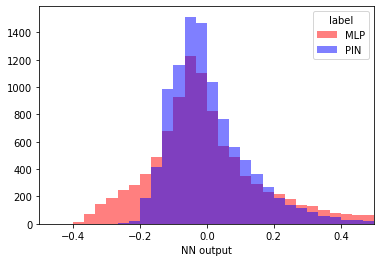

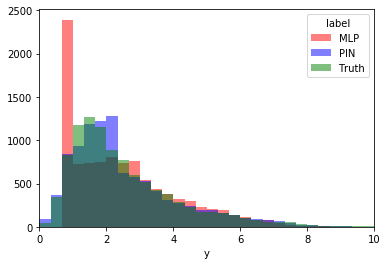

4 1


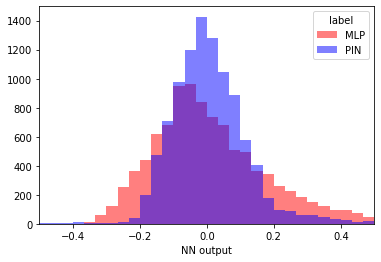

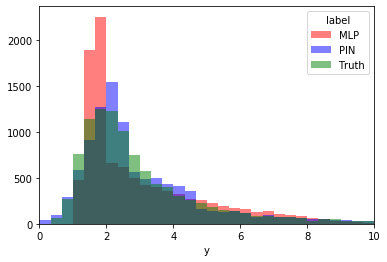

5 1


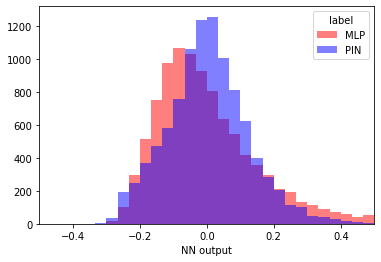

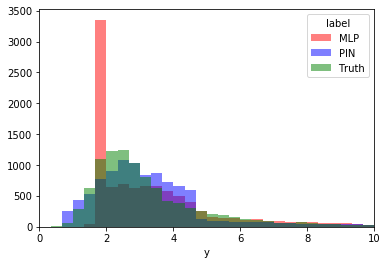

In [60]:
# Let's take a look at how our model performs
for N in Nkeys:
    for i in modelkeys:
        print(N,i)

        out_mlp = mlp[N][i](xval_dict[N]).squeeze()
        out_pin = pin[N][i](xval_dict[N]).squeeze()

        yval = yval_dict[N].resize(len(yval_dict[N]))

        frac_error_mlp = torch.div((out_mlp-yval),yval)
        frac_error_pin = torch.div((out_pin-yval),yval)

        plt.hist(frac_error_mlp.detach().numpy(),bins=30,range=(-0.5,0.5),alpha=0.5,color='red',label="MLP")
        plt.hist(frac_error_pin.detach().numpy(),bins=30,range=(-0.5,0.5),alpha=0.5,color='blue',label="PIN")
        plt.xlim(-0.5,0.5)
        plt.legend(title="label")
        #plt.yscale("log")
        plt.xlabel("NN output")
        plt.show()

        plt.hist(out_mlp.detach().numpy(),bins=30,range=(0,10),alpha=0.5,color='red',label="MLP")
        plt.hist(out_pin.detach().numpy(),bins=30,range=(0,10),alpha=0.5,color='blue',label="PIN")
        plt.hist(yval,bins=30,range=(0,10),alpha=0.5,color='green',label="Truth")
        plt.xlim(0,10)
        plt.legend(title="label")
        #plt.yscale("log")
        plt.xlabel("y")
        plt.show()

In [61]:
# Now we will print the weights of the hidden layer
for N in Nkeys:
    for key in modelkeys:
        modules = list(mlp[N][key].modules())
        print(modules[0].mlp[0].weight)
        print(modules[0].mlp[2].weight)

from itertools import permutations

rm_mlp = {N:{key:[] for key in modelkeys} for N in Nkeys}
rm_pin = {N:{key:[] for key in modelkeys} for N in Nkeys}

for N in Nkeys:
    print('N:',N)
    for i in range(1000):
        if(i%100==0): print(i)
        test = np.random.random(N)
        test_permuted = test[torch.randperm(N)]
        tests = torch.from_numpy(np.array([test,test_permuted]))

        #test_permuted = np.array([np.array(p) for p in list(permutations(test))[1:3]])
        y = f(np.array([test,test_permuted]))
        for key in modelkeys:
            yhat_mlp = np.array([mlp[N][key](t.float()).detach().numpy() for t in tests])
            rm_mlp[N][key].append((np.max(yhat_mlp) - np.min(yhat_mlp))/y[0])


    


Parameter containing:
tensor([[-0.4235, -0.2009, -0.3073],
        [ 1.0615,  0.8942,  0.9755],
        [-0.2403, -0.5735, -0.3854]], requires_grad=True)
Parameter containing:
tensor([[-0.4008,  0.0898, -0.5642],
        [-0.4435,  0.6373,  0.0867],
        [-0.2191,  0.0064, -0.5555],
        [ 0.5653,  1.6549, -0.6441],
        [-0.0465, -0.4075, -0.1029],
        [-0.1824, -0.4255, -0.1551],
        [ 0.3513,  0.0244, -0.4185],
        [ 0.4928,  0.0887, -0.4676],
        [ 0.1538,  0.7978, -0.9007],
        [-0.0957, -0.4913,  0.4784]], requires_grad=True)
Parameter containing:
tensor([[-0.0411, -0.3104,  0.0016, -0.3091],
        [ 0.3797,  0.6169,  0.7694,  0.9682],
        [ 1.0032,  0.7526,  0.5648,  0.3400],
        [ 0.2565, -0.4616, -0.4119, -0.0318]], requires_grad=True)
Parameter containing:
tensor([[-0.0805, -0.2171, -0.0384,  0.1146],
        [ 0.1432,  0.4669,  0.4274, -0.3439],
        [-0.3243,  1.5178,  1.1092, -0.1559],
        [ 0.2888,  0.1196, -0.1364,  0.1287],


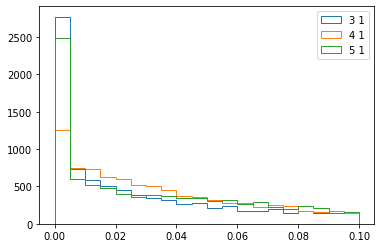

In [20]:

for N in Nkeys:
    for key in modelkeys:
        plt.hist(rm_mlp[N][key],bins=20,range=(0,0.1),alpha=1.0,label=str(N)+' '+key,histtype='step')
plt.legend()
#plt.semilogy()
plt.show()